In this file we wiil build different models, in different datasets and hyperparameters using PyTorch.

In [2]:
# Connection with google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [71]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import os
import random
from PIL import Image
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')


### Initialize some parameters that will be used throughout the notebook

In [72]:
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

### Setup the device


In [73]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cpu


### Create the going_modular folder

In the `going_modular` folder we will store all the functions we have create through out the notebook.

In [74]:
import os
os.makedirs("/content/drive/MyDrive/my_projects/animal_classification/going_modular", exist_ok = True)

## 1. Import the data.

In the `data_preprocess` folder we modify our data in a way we want. We also create 3 different dataset
* `transformed_dataset_25_images`
* `transformed_dataset_50_images`
* `transformed_dataset_100_images`

During the process of building some models, we will use the first of the three datasets.

In [75]:
# Create the path of the dataset you are using
folder_path = '/content/drive/MyDrive/my_projects/animal_classification/transformed_dataset_50_images'

# Create train, test and validation sets
train_data = folder_path + '/train'
valid_data = folder_path + '/valid'
test_data = folder_path + '/test'

## 2. Create datasets and DataLoaders
### 2.1 Create datasets


In [76]:
# Let's import our modules
from torchvision import datasets
from torchvision import transforms

# Create ImageNet normalization levels.
normalize = transforms.Normalize(mean = [0.485, 0.456, 0.406],
                                 std = [0.229, 0.224, 0.225])

# Create the transfrom.
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    normalize
])

# Create datasets and apply the transform.
train_dataset = datasets.ImageFolder(train_data, transform = transform)
valid_dataset = datasets.ImageFolder(valid_data, transform = transform)
test_dataset = datasets.ImageFolder(test_data, transform = transform)


### 2.2 Create DataLoaders.


In [77]:
# CReate dataloaders.
train_dataloader = DataLoader(train_dataset, batch_size = 32, shuffle = True)
valid_dataloader = DataLoader(valid_dataset, batch_size = 32, shuffle = False)
test_dataloader = DataLoader(test_dataset, batch_size = 32, shuffle = False)

### 2.3 Create autotransformer
Because we are going to use EfficientNet_B0, PyTorch gives us the opportunities to use the pre-build transformer for this model

In [78]:
import torchvision

# Create dataloaders base on the model we will be us
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
auto_transformer = weights.transforms()

auto_transformer

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [79]:
train_dataset= datasets.ImageFolder(train_data, transform = auto_transformer)
train_dataloader = DataLoader(train_dataset, batch_size = 32, shuffle = True)

test_dataset = datasets.ImageFolder(test_data, transform = auto_transformer)
test_dataloader = DataLoader(test_dataset, batch_size = 32, shuffle = False)

valid_dataset = datasets.ImageFolder(valid_data, transform = auto_transformer)
valid_dataloader = DataLoader(valid_dataset, batch_size = 32, shuffle = False)


In [80]:
train_dataset.classes

['butterfly',
 'cat',
 'chicken',
 'cow',
 'dog',
 'elephant',
 'horse',
 'sheep',
 'spider',
 'squirrel']

### 2.4 Functionize the process
Because of the fact that we already created dataloaders, is a good idea to functionaze this.

We will also save the code as `.py`.

In [81]:
%%writefile /content/drive/MyDrive/my_projects/animal_classification/going_modular/data_setup.py
"""
  Contains functionality for creating PyToarch Dataloaders for
  image classification.
"""
import os
import torchvision
from torchvision import transforms
from torchvision import datasets
from torch.utils.data import DataLoader

NUM_WORKERS = os.cpu_count()

# Create a function that create Dataloaders
def create_dataloader(train_data: str,
                      test_data: str,
                      valid_data: str = None,
                      transform: transforms.Compose = None,
                      batch_size: int = 32,
                      num_workers :int = NUM_WORKERS):

    """ Create training, testing and validation dataloaders.

    Args:
      - train_data (str): Path to train directory
      - test_data (str) : Path to test directory
      - valid_data (str): Path to valid directory
      - transform (tranform.Compose) : Transform to perform on data (images)
      - batch_size (int) : Number of samples per batch in each of the Dataloaders

    Return:
      A tuple of the following:
        - train_dataloader (DataLoader)
        - test_dataloader (DataLoader)
        - valid_dataloader (DataLoader)
        - class_names (list) : List of the class names

    """

    # Create datasets for train and test
    train_dataset = datasets.ImageFolder(train_data, transform = transform)
    test_dataset = datasets.ImageFolder(test_data, transform = transform)

    # Create dataset and dataloader for validation if exists
    if valid_data:
      valid_dataset = datasets.ImageFolder(valid_data, transform = transform)
      valid_dataloader = DataLoader(valid_dataset, batch_size = batch_size, shuffle = False,
                                    num_workers = num_workers)
    else:
      print(f"[INFO] We don't have validation dataset")

    # the names of classes are
    class_names = train_dataset.classes

    # Create dataloaders
    train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True,
                                  num_workers = num_workers)
    test_dataloader = DataLoader(test_dataset, batch_size = batch_size , shuffle = False,
                                 num_workers = num_workers)

    print(f"[INFO] Dataloaders and datasets are created")

    return train_dataloader, test_dataloader, valid_dataloader, class_names

Overwriting /content/drive/MyDrive/my_projects/animal_classification/going_modular/data_setup.py


### 2.5 Create dataloaders using the function

In [82]:
import os

os.chdir("/content/drive/MyDrive/my_projects/animal_classification/going_modular/")

import data_setup


train_dataloader, test_dataloader, valid_dataloader, class_names=data_setup.create_dataloader(train_data = train_data,
                                                                                    test_data= test_data,
                                                                                    valid_data = valid_data,
                                                                                    batch_size = BATCH_SIZE,
                                                                                    transform= auto_transformer)

[INFO] Dataloaders and datasets are created


### 2.6 Visualize some images after the transformer


In [83]:
from typing import Dict, List, Tuple


# 1. Take in a Dataset as well as a list of class names
def display_random_images(dataset: torch.utils.data.dataset.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):

    # 2. Adjust display if n too high
    if n > 10:
        n = 10
        display_shape = False
        print(f"For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.")

    # 3. Set random seed
    if seed:
        random.seed(seed)

    # 4. Get random sample indexes
    random_samples_idx = random.sample(range(len(dataset)), k=n)

    # 5. Setup plot
    plt.figure(figsize=(16, 8))

    # 6. Loop through samples and display random samples
    for i, targ_sample in enumerate(random_samples_idx):
        targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

        # 7. Adjust image tensor shape for plotting: [color_channels, height, width] -> [color_channels, height, width]
        targ_image_adjust = targ_image.permute(1, 2, 0)

        # Plot adjusted samples
        plt.subplot(1, n, i+1)
        plt.imshow(targ_image_adjust)
        plt.axis("off")
        if classes:
            title = f"class: {classes[targ_label]}"
            if display_shape:
                title = title + f"\nshape: {targ_image_adjust.shape}"
        plt.title(title)

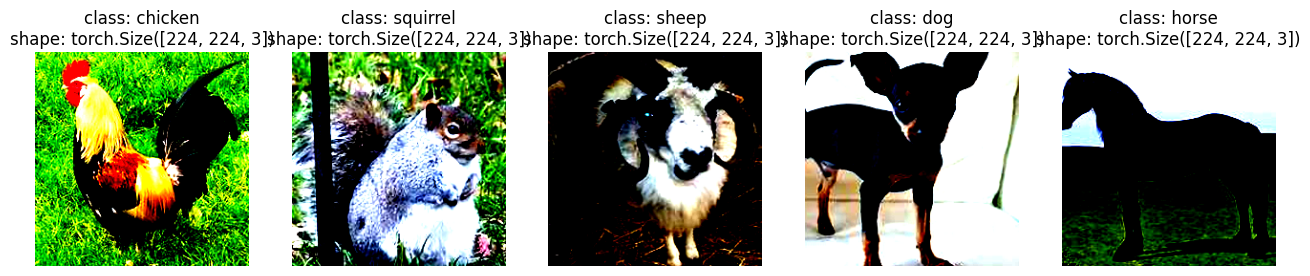

In [84]:
# Display random images from ImageFolder created Dataset
display_random_images(train_dataset,
                      n=5,
                      classes=class_names,
                      seed=None)

## 3. Get the pretrained model, freeze the base layer and change the classifier


In [85]:
%%writefile /content/drive/MyDrive/my_projects/animal_classification/going_modular/model_builder.py
"""
Contains PyTorch model code to instantiate a TinyVGG model.
"""
import torch
from torch import nn
# Create the model
model = torchvision.models.efficientnet_b0(weights = weights).to(device)


# Freeze the layers
for param in model.parameters():
    param.requires_grad = False

# Change the classifier
model.classifier = nn.Sequential(
    nn.Dropout(p = 0.2, inplace = True),
    nn.Linear(in_features = 1280, out_features = len(class_names))
    ).to(device)

Overwriting /content/drive/MyDrive/my_projects/animal_classification/going_modular/model_builder.py


### 3.1 Print the summary of the model.

In [86]:
try:
  from torchinfo import summary
except:
  print("[INFO] Couldn't find torchinfo... installing it.")
  !pip install -q torchinfo
  from torchinfo import summary

In [87]:
from torchinfo import summary
from model_builder import create_model
import torchvision

model

summary(model = model,
        input_size = (32, 3, 224, 224),
        col_names = ["input_size", "output_size", "num_params", "trainable"],
        col_width = 20,
        row_settings = ['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 10]             --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

## 4. Build the model
We will try to create a loop that trains our model and we will impove the method step by step.


### 4.1 Define the optimizer and the loss function

In [88]:
# Define optimizer and loss function
optimizer = torch.optim.Adam(params = model.parameters(), lr = 0.001)
loss_fn = nn.CrossEntropyLoss()

In [89]:
def accuracy_fn(y_true, y_pred):
    """Calculates accuracy between truth labels and predictions.

    Args:
        y_true (torch.Tensor): Truth labels for predictions.
        y_pred (torch.Tensor): Predictions to be compared to predictions.

    Returns:
        [torch.float]: Accuracy value between y_true and y_pred, e.g. 78.45
    """
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

### 4.2 Create the training and testing step.

In [90]:
'''from tqdm.auto import tqdm

# Set the manual seed.
torch.manual_seed(42)

# Set the epochs
EPOCHS = 5

# Create the training loop
for epoch in tqdm(range(EPOCHS)):
    print(f"Epoch {epoch+1} \n -----------------------------------")

    #### TRaining step
    train_loss , train_acc = 0, 0

    # Add a loop to walk through all batches
    for batch, (X, y) in enumerate(train_dataloader):
        # Set the model into training mode
        model.train()

        # # SEnd data to the target device
        X, y = X.to(device), y.to(device)

        # Forward pass
        y_pred = model(X)

        # Calculate the loss and the accuracy
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y_true = y, y_pred = y_pred.argmax(dim = 1))

        # Optimizer zero grad
        optimizer.zero_grad()

        # Loss backward
        loss.backward()

        # Optimizer step
        optimizer.step()

        # Print out what's happening
        if batch % 400 == 0:
            print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples")

    # Calculate the total accuracy and loss
    train_acc /= len(train_dataloader)
    train_loss /= len(train_dataloader)

    ### Testing step



    # Setup the testing loop

    test_loss, test_acc = 0, 0
    # Turn the model into testing mode
    model.eval()
    with torch.inference_mode():

        for X_test, y_test in test_dataloader:

            # SEnd to the target device
            X_test , y_test = X_test.to(device), y_test.to(device)
            # 1. Forward pass
            test_pred = model(X_test)

            # 2. Calculate the accuracy and the loss
            test_loss  += loss_fn(test_pred, y_test)

            # 3. Calculate the accuracy
            test_acc += accuracy_fn(y_true = y_test, y_pred = test_pred.argmax(dim = 1))

        # 4. Calculate the test loss average per batch
        test_loss /= len(test_dataloader)
        test_acc /= len(test_dataloader)

    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}% | Test Loss {test_loss:.4f} | Test Accuracy {test_acc}")

'''

'from tqdm.auto import tqdm\n\n# Set the manual seed.\ntorch.manual_seed(42)\n\n# Set the epochs\nEPOCHS = 5\n\n# Create the training loop\nfor epoch in tqdm(range(EPOCHS)):\n    print(f"Epoch {epoch+1} \n -----------------------------------")\n\n    #### TRaining step\n    train_loss , train_acc = 0, 0\n\n    # Add a loop to walk through all batches\n    for batch, (X, y) in enumerate(train_dataloader):\n        # Set the model into training mode\n        model.train()\n\n        # # SEnd data to the target device\n        X, y = X.to(device), y.to(device)\n\n        # Forward pass\n        y_pred = model(X)\n\n        # Calculate the loss and the accuracy\n        loss = loss_fn(y_pred, y)\n        train_loss += loss\n        train_acc += accuracy_fn(y_true = y, y_pred = y_pred.argmax(dim = 1))\n\n        # Optimizer zero grad\n        optimizer.zero_grad()\n\n        # Loss backward\n        loss.backward()\n\n        # Optimizer step\n        optimizer.step()\n\n        # Print out

### 4.3 Functionaize the previous
Because we create lots of code taht we want to use again.
we will create 3 function:
- `train_step()` : Will contain the training step
- `test_step()`: Will contain the testing step
- `train()`: Trains and test the model.

#### 4.3.1 Create the train_step()

In [91]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:
  """Trains a PyTorch model for a single epoch.

  Turns a target PyTorch model to training mode and then
  runs through all of the required training steps (forward
  pass, loss calculation, optimizer step).

  Args:
    model: A PyTorch model to be trained.
    dataloader: A DataLoader instance for the model to be trained on.
    loss_fn: A PyTorch loss function to minimize.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    device: A target device to compute on (e.g. "cuda" or "cpu").

  Returns:
    A tuple of training loss and training accuracy metrics.
    In the form (train_loss, train_accuracy). For example:

    (0.1112, 0.8743)
  """
  # Put model in train mode
  model.train()

  # Setup train loss and train accuracy values
  train_loss, train_acc = 0, 0

  # Loop through data loader data batches
  for batch, (X, y) in enumerate(dataloader):
      # Send data to target device
      X, y = X.to(device), y.to(device)

      # 1. Forward pass
      y_pred = model(X)

      # 2. Calculate  and accumulate loss
      loss = loss_fn(y_pred, y)
      train_loss += loss.item()

      # 3. Optimizer zero grad
      optimizer.zero_grad()

      # 4. Loss backward
      loss.backward()

      # 5. Optimizer step
      optimizer.step()

      # Calculate and accumulate accuracy metric across all batches
      y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
      train_acc += (y_pred_class == y).sum().item()/len(y_pred)

  # Adjust metrics to get average loss and accuracy per batch
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss, train_acc

#### 4.3.2 Create the test step()


In [92]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:
  """Tests a PyTorch model for a single epoch.

  Turns a target PyTorch model to "eval" mode and then performs
  a forward pass on a testing dataset.

  Args:
    model: A PyTorch model to be tested.
    dataloader: A DataLoader instance for the model to be tested on.
    loss_fn: A PyTorch loss function to calculate loss on the test data.
    device: A target device to compute on (e.g. "cuda" or "cpu").

  Returns:
    A tuple of testing loss and testing accuracy metrics.
    In the form (test_loss, test_accuracy). For example:

    (0.0223, 0.8985)
  """
  # Put model in eval mode
  model.eval()

  # Setup test loss and test accuracy values
  test_loss, test_acc = 0, 0

  # Turn on inference context manager
  with torch.inference_mode():
      # Loop through DataLoader batches
      for batch, (X, y) in enumerate(dataloader):
          # Send data to target device
          X, y = X.to(device), y.to(device)

          # 1. Forward pass
          test_pred_logits = model(X)

          # 2. Calculate and accumulate loss
          loss = loss_fn(test_pred_logits, y)
          test_loss += loss.item()

          # Calculate and accumulate accuracy
          test_pred_labels = test_pred_logits.argmax(dim=1)
          test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

  # Adjust metrics to get average loss and accuracy per batch
  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)
  return test_loss, test_acc

#### 4.3.3 Create the train function

In [93]:
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn : torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List[float]]:

    # Create an empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }

    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model = model,
                                           dataloader = train_dataloader,
                                           loss_fn = loss_fn,
                                           optimizer = optimizer,
                                           device = device)

        test_loss, test_acc = test_step(model = model,
                                        dataloader = valid_dataloader,
                                        loss_fn = loss_fn,
                                        device = device)

    # Print out what's happening
    print(
        f"Epoch: {epoch+1} | "
        f"train_loss: {train_loss:.4f} | "
        f"train_acc: {train_acc:.4f} |"
        f"test_loss: {test_loss:.4f} |"
        f"test_acc: {test_acc:.4f}"
    )

    # Update results in dictionary
    results['train_loss'].append(train_loss)
    results['train_acc'].append(train_acc)
    results['test_loss'].append(test_loss)
    results['test_acc'].append(test_acc)

    return results

### 4.3.4 Train the model

In [ ]:
from tqdm.auto import tqdm

train(model = model,
      train_dataloader = train_dataloader,
      test_dataloader = valid_dataloader,
      epochs = 5,
      optimizer = optimizer,
      loss_fn = loss_fn,
      device = device)

  0%|          | 0/5 [00:00<?, ?it/s]

### 4.4 Create `train_step()` , `test_step()` and `train()` function to combine them


In [ ]:
%%writefile /content/drive/MyDrive/my_projects/animal_classification/going_modular/engine.py
"""
Contains functions for training and testing a PyTorch model.
"""

from typing import Dict, List, Tuple
import torch
from tqdm.auto import tqdm


def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:
  """Trains a PyTorch model for a single epoch.

  Turns a target PyTorch model to training mode and then
  runs through all of the required training steps (forward
  pass, loss calculation, optimizer step).

  Args:
    model: A PyTorch model to be trained.
    dataloader: A DataLoader instance for the model to be trained on.
    loss_fn: A PyTorch loss function to minimize.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    device: A target device to compute on (e.g. "cuda" or "cpu").

  Returns:
    A tuple of training loss and training accuracy metrics.
    In the form (train_loss, train_accuracy). For example:

    (0.1112, 0.8743)
  """
  # Put model in train mode
  model.train()

  # Setup train loss and train accuracy values
  train_loss, train_acc = 0, 0

  # Loop through data loader data batches
  for batch, (X, y) in enumerate(dataloader):
      # Send data to target device
      X, y = X.to(device), y.to(device)

      # 1. Forward pass
      y_pred = model(X)

      # 2. Calculate  and accumulate loss
      loss = loss_fn(y_pred, y)
      train_loss += loss.item()

      # 3. Optimizer zero grad
      optimizer.zero_grad()

      # 4. Loss backward
      loss.backward()

      # 5. Optimizer step
      optimizer.step()

      # Calculate and accumulate accuracy metric across all batches
      y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
      train_acc += (y_pred_class == y).sum().item()/len(y_pred)

  # Adjust metrics to get average loss and accuracy per batch
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss, train_acc


def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:
  """Tests a PyTorch model for a single epoch.

  Turns a target PyTorch model to "eval" mode and then performs
  a forward pass on a testing dataset.

  Args:
    model: A PyTorch model to be tested.
    dataloader: A DataLoader instance for the model to be tested on.
    loss_fn: A PyTorch loss function to calculate loss on the test data.
    device: A target device to compute on (e.g. "cuda" or "cpu").

  Returns:
    A tuple of testing loss and testing accuracy metrics.
    In the form (test_loss, test_accuracy). For example:

    (0.0223, 0.8985)
  """
  # Put model in eval mode
  model.eval()

  # Setup test loss and test accuracy values
  test_loss, test_acc = 0, 0

  # Turn on inference context manager
  with torch.inference_mode():
      # Loop through DataLoader batches
      for batch, (X, y) in enumerate(dataloader):
          # Send data to target device
          X, y = X.to(device), y.to(device)

          # 1. Forward pass
          test_pred_logits = model(X)

          # 2. Calculate and accumulate loss
          loss = loss_fn(test_pred_logits, y)
          test_loss += loss.item()

          # Calculate and accumulate accuracy
          test_pred_labels = test_pred_logits.argmax(dim=1)
          test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

  # Adjust metrics to get average loss and accuracy per batch
  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)
  return test_loss, test_acc


def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List[float]]:
  """Trains and tests a PyTorch model.

  Passes a target PyTorch models through train_step() and test_step()
  functions for a number of epochs, training and testing the model
  in the same epoch loop.

  Calculates, prints and stores evaluation metrics throughout.

  Args:
    model: A PyTorch model to be trained and tested.
    train_dataloader: A DataLoader instance for the model to be trained on.
    test_dataloader: A DataLoader instance for the model to be tested on.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    loss_fn: A PyTorch loss function to calculate loss on both datasets.
    epochs: An integer indicating how many epochs to train for.
    device: A target device to compute on (e.g. "cuda" or "cpu").

  Returns:
    A dictionary of training and testing loss as well as training and
    testing accuracy metrics. Each metric has a value in a list for
    each epoch.
    In the form: {train_loss: [...],
                  train_acc: [...],
                  test_loss: [...],
                  test_acc: [...]}
    For example if training for epochs=2:
                 {train_loss: [2.0616, 1.0537],
                  train_acc: [0.3945, 0.3945],
                  test_loss: [1.2641, 1.5706],
                  test_acc: [0.3400, 0.2973]}
  """
  # Create empty results dictionary
  results = {"train_loss": [],
      "train_acc": [],
      "test_loss": [],
      "test_acc": []
  }

  # Loop through training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs)):
      train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
      test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

      # Print out what's happening
      print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
      )

      # Update results dictionary
      results["train_loss"].append(train_loss)
      results["train_acc"].append(train_acc)
      results["test_loss"].append(test_loss)
      results["test_acc"].append(test_acc)

  # Return the filled results at the end of the epochs
  return results

## 5. Save the model
Save the file to going_modular as `utils.py`

In [ ]:
%%writefile '/content/drive/MyDrive/my_projects/animal_classification/going_modular/utils.py'
"""
  Contains varius functions for PyTorch model training and saving.
"""

import torch
from pathlib import Path
def save_model(model: torch.nn.Module,
               target_dir: str,
               model_name: str):
  """Saves a PyTorch model to a target directory.

  Args:
    model: A target PyTorch model to save.
    target_dir: A directory for saving the model to.
    model_name: A filename for the saved model. Should include
      either ".pth" or ".pt" as the file extension.

  Example usage:
    save_model(model=model_0,
               target_dir="models",
               model_name="05_going_modular_tingvgg_model.pth")
  """
  # Create target directory
  target_dir_path = Path(target_dir)
  target_dir_path.mkdir(parents=True,
                        exist_ok=True)

  torch.save(obj=model.state_dict(),
             f=target_dir_path / model_name)


def accuracy_fn(y_true, y_pred):
    """Calculates accuracy between truth labels and predictions.

    Args:
        y_true (torch.Tensor): Truth labels for predictions.
        y_pred (torch.Tensor): Predictions to be compared to predictions.

    Returns:
        [torch.float]: Accuracy value between y_true and y_pred, e.g. 78.45
    """
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

from typing import Dict, List, Tuple


# 1. Take in a Dataset as well as a list of class names
def display_random_images(dataset: torch.utils.data.dataset.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):

    # 2. Adjust display if n too high
    if n > 10:
        n = 10
        display_shape = False
        print(f"For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.")

    # 3. Set random seed
    if seed:
        random.seed(seed)

    # 4. Get random sample indexes
    random_samples_idx = random.sample(range(len(dataset)), k=n)

    # 5. Setup plot
    plt.figure(figsize=(16, 8))

    # 6. Loop through samples and display random samples
    for i, targ_sample in enumerate(random_samples_idx):
        targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

        # 7. Adjust image tensor shape for plotting: [color_channels, height, width] -> [color_channels, height, width]
        targ_image_adjust = targ_image.permute(1, 2, 0)

        # Plot adjusted samples
        plt.subplot(1, n, i+1)
        plt.imshow(targ_image_adjust)
        plt.axis("off")
        if classes:
            title = f"class: {classes[targ_label]}"
            if display_shape:
                title = title + f"\nshape: {targ_image_adjust.shape}"
        plt.title(title)

In [ ]:
# train the model
import utils, engine
from utils import save_model
from engine import train
import torch

optimizer = torch.optim.Adam(params = model.parameters(), lr = 0.001)
loss_fn = nn.CrossEntropyLoss()

train(model = model,train_dataloader = train_dataloader,
      test_dataloader = valid_dataloader,
      optimizer = optimizer, loss_fn = loss_fn,
      epochs = 5,
      device = device)

### 6.1 Load the model again.

In [ ]:
save_model(model = model,
          target_dir = '/content/drive/MyDrive/my_projects/animal_classification/models',
           model_name = 'first_model_50_images.pth')

loaded_model = torch.load('/content/drive/MyDrive/my_projects/animal_classification/models/first_model_50_images.pth', weights_only=False)


## 6. Evaluation
### 6.1 Import torchmetrics and mlxtend
Ensure that the modules are installed or install them and then import..

In [ ]:
# See if torchmetrics exists, if not, install it
try:
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")
    assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend verison should be 0.19.0 or higher"
except:
    !pip install -q torchmetrics -U mlxtend # <- Note: If you're using Google Colab, this may require restarting the runtime
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")

### 6.2 Make predictions

In [ ]:
%%writefile '/content/drive/MyDrive/my_projects/animal_classification/going_modular/prediction.py'
"""
  Contains functionallities to make predictions and evaluate the model.
"""
# Import tqdm for progress bar
from tqdm.auto import tqdm
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

device = 'cuda' if torch.cuda.is_available() else 'cpu'
def make_predictions(model: torch.nn.Module,
                            test_dataloader: torch.utils.data.DataLoader, device = device):
    # 1. Make predictions with trained model
    y_preds = []
    y_targets = []  # Collect true targets to avoid re-fetching them
    model.eval()
    with torch.inference_mode():
        for X, y in tqdm(test_dataloader, desc="Making predictions"):
            # Send data and targets to target device
            X, y = X.to(device), y.to(device)
            # Do the forward pass
            y_logit = model(X)
            # Turn predictions from logits -> prediction probabilities -> prediction labels
            y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1)
            # Collect predictions and targets
            y_preds.append(y_pred.cpu())  # Move predictions to CPU
            y_targets.append(y.cpu())     # Move targets to CPU

    # Concatenate list of predictions and targets into tensors
    y_pred_tensor = torch.cat(y_preds)
    y_target_tensor = torch.cat(y_targets)

    # Ensure both predictions and targets are on the same device (e.g., CPU)
    device = 'cpu'  # Change to 'cuda' if using GPU
    y_pred_tensor = y_pred_tensor.to(device)
    y_target_tensor = y_target_tensor.to(device)

    return(y_pred_tensor, y_target_tensor)

# Apply the function to create the predictions
y_pred_tensor , y_target_tensor = make_predictions(model = model, test_dataloader = valid_dataloader)

# 2. Setup confusion matrix instance and compare predictions to targets
confmat = ConfusionMatrix(num_classes=len(class_names), task='multiclass').to(device)  # Ensure metric is on the same device
confmat_tensor = confmat(preds=y_pred_tensor, target=y_target_tensor)

# 3. Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(),  # matplotlib likes working with NumPy
    class_names=class_names,          # turn the row and column labels into class names
    figsize=(10, 7)
)

def accuracy_score(y_true, y_pred):
    # find the accuracy of the model in test set
    testing_accuracy = accuracy_fn(y_true =y_target_tensor , y_pred =y_pred_tensor )
    print(f"The testing accuracy is {testing_accuracy}")

def classification_report(y_true, y_pred):
  from sklearn.metrics import classification_report

  # Generate the classification report as a dictionary
  report = classification_report(y_target_tensor, y_pred_tensor, target_names=class_names, output_dict=True)

  # Filter out the overall metrics (like accuracy, macro avg, etc.)
  class_metrics = {label: metrics for label, metrics in report.items() if isinstance(metrics, dict)}

  # Find classes with the lowest recall and precision
  sorted_by_recall = sorted(class_metrics.items(), key=lambda x: x[1].get('recall', 0))
  sorted_by_precision = sorted(class_metrics.items(), key=lambda x: x[1].get('precision', 0))

  print("Classes with the lowest recall:")
  for label, metrics in sorted_by_recall[:3]:  # Show top 3 problematic classes
      print(f"{label}: Recall = {metrics.get('recall', 'N/A')}")

  print("\nClasses with the lowest precision:")
  for label, metrics in sorted_by_precision[:3]:  # Show top 3 problematic classes
      print(f"{label}: Precision = {metrics.get('precision', 'N/A')}")


In [ ]:
# Import tqdm for progress bar
from tqdm.auto import tqdm
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

device = 'cuda' if torch.cuda.is_available() else 'cpu'
def make_predictions(model: torch.nn.Module,
                            test_dataloader: torch.utils.data.DataLoader, device = device):
    # 1. Make predictions with trained model
    y_preds = []
    y_targets = []  # Collect true targets to avoid re-fetching them
    model.eval()
    with torch.inference_mode():
        for X, y in tqdm(test_dataloader, desc="Making predictions"):
            # Send data and targets to target device
            X, y = X.to(device), y.to(device)
            # Do the forward pass
            y_logit = model(X)
            # Turn predictions from logits -> prediction probabilities -> prediction labels
            y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1)
            # Collect predictions and targets
            y_preds.append(y_pred.cpu())  # Move predictions to CPU
            y_targets.append(y.cpu())     # Move targets to CPU

    # Concatenate list of predictions and targets into tensors
    y_pred_tensor = torch.cat(y_preds)
    y_target_tensor = torch.cat(y_targets)

    # Ensure both predictions and targets are on the same device (e.g., CPU)
    device = 'cpu'  # Change to 'cuda' if using GPU
    y_pred_tensor = y_pred_tensor.to(device)
    y_target_tensor = y_target_tensor.to(device)

    return(y_pred_tensor, y_target_tensor)

### 6.3 Create the confusion matrix

In [ ]:
# Apply the function to create the predictions
y_pred_tensor , y_target_tensor = make_predictions(model = model, test_dataloader = valid_dataloader)

# 2. Setup confusion matrix instance and compare predictions to targets
confmat = ConfusionMatrix(num_classes=len(class_names), task='multiclass').to(device)  # Ensure metric is on the same device
confmat_tensor = confmat(preds=y_pred_tensor, target=y_target_tensor)

# 3. Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(),  # matplotlib likes working with NumPy
    class_names=class_names,          # turn the row and column labels into class names
    figsize=(10, 7)
)

In [ ]:
# find the accuracy of the model in test set
testing_accuracy = accuracy_fn(y_true =y_target_tensor , y_pred =y_pred_tensor )
print(f"The testing accuracy is {testing_accuracy}")

In [ ]:
from sklearn.metrics import classification_report

# Generate the classification report as a dictionary
report = classification_report(y_target_tensor, y_pred_tensor, target_names=class_names, output_dict=True)

# Filter out the overall metrics (like accuracy, macro avg, etc.)
class_metrics = {label: metrics for label, metrics in report.items() if isinstance(metrics, dict)}

# Find classes with the lowest recall and precision
sorted_by_recall = sorted(class_metrics.items(), key=lambda x: x[1].get('recall', 0))
sorted_by_precision = sorted(class_metrics.items(), key=lambda x: x[1].get('precision', 0))

print("Classes with the lowest recall:")
for label, metrics in sorted_by_recall[:3]:  # Show top 3 problematic classes
    print(f"{label}: Recall = {metrics.get('recall', 'N/A')}")

print("\nClasses with the lowest precision:")
for label, metrics in sorted_by_precision[:3]:  # Show top 3 problematic classes
    print(f"{label}: Precision = {metrics.get('precision', 'N/A')}")


In [ ]:
report = classification_report(y_target_tensor, y_pred_tensor, target_names=class_names, )
print(report)